## Load required libraries

In [1]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import joblib 

from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
import scipy.stats as st

## Load the dataset: We work with the daily data for the ML approach

In [3]:
df = pd.read_csv('../dataset/day.csv')

## Data exploration

In [4]:
df.shape

(731, 16)

In [5]:
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Preprocessing

In [7]:
df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [8]:
df.drop('rec_id', axis=1, inplace=True)

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['datetime']=pd.to_datetime(df.datetime)

df['season']=df.season.astype('category')
df['year']=df.year.astype('category')
df['month']=df.month.astype('category')
df['holiday']=df.holiday.astype('category')
df['weekday']=df.weekday.astype('category')
df['workingday']=df.workingday.astype('category')
df['weather_condition']=df.weather_condition.astype('category')

In [10]:
df.set_index('datetime', inplace=True)

In [11]:
df.head()

,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
datetime,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [12]:
df.describe()

,temp,atemp,humidity,windspeed,casual,registered,total_count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [13]:
df.isnull().sum()

season               0
year                 0
month                0
holiday              0
weekday              0
workingday           0
weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
total_count          0
dtype: int64

### Remove highly correlated (redundant) features

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

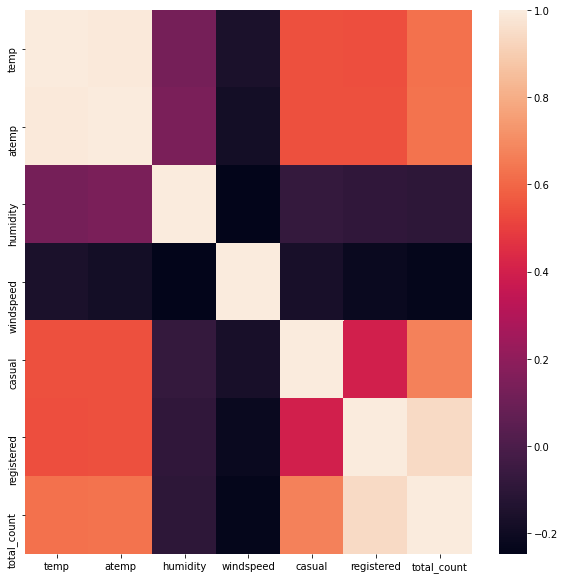

In [14]:
# Check for correlation
plt.figure(figsize = (10,10)), sns.heatmap(df.corr())

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

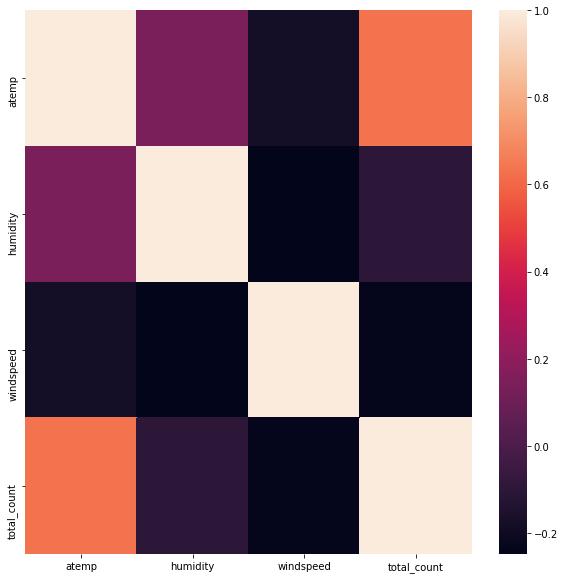

In [15]:
# Remove highly correlated values

df.drop(['casual','registered','temp'], axis = 1, inplace = True)

# Verify

plt.figure(figsize = (10,10)), sns.heatmap(df.corr())

In [332]:
df.columns

Index(['season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather_condition', 'atemp', 'humidity', 'windspeed', 'total_count'],
      dtype='object')

### Outlier analysis of numerical variables

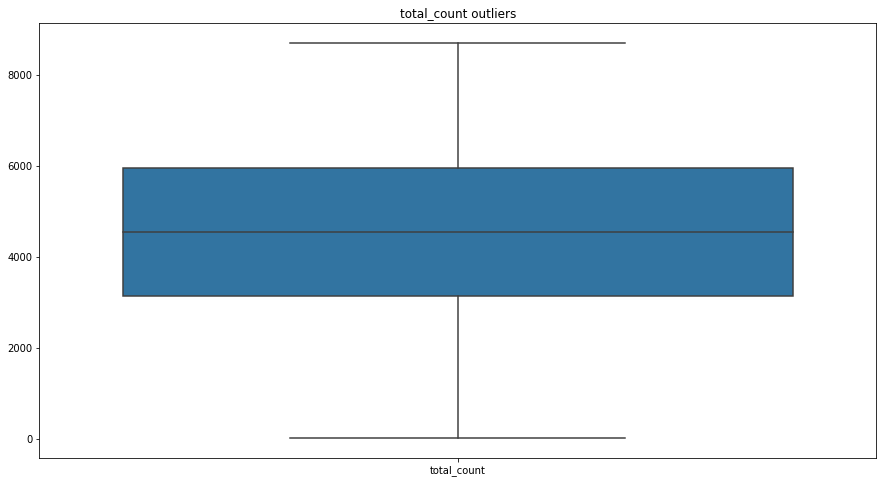

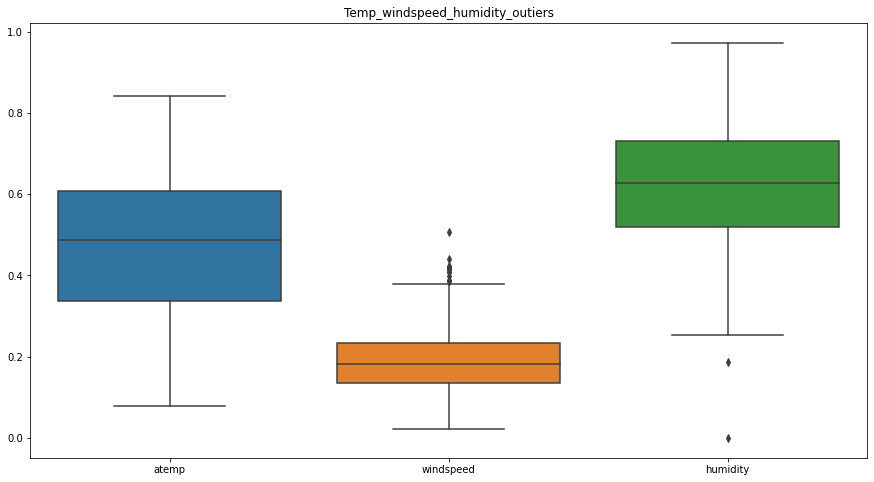

In [16]:
# Total count
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=df[['total_count']])
ax.set_title('total_count outliers')
plt.show()

# Temp, windspeed, humidity

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=df[['atemp','windspeed','humidity']])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

### Impute the outlier values

In [17]:
#create dataframe for outliers
wind_hum=pd.DataFrame(df,columns=['windspeed','humidity'])
 #Cnames for outliers                     
cnames=['windspeed','humidity']       
                      
for i in cnames:
    q75,q25=np.percentile(wind_hum.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    wind_hum.loc[wind_hum.loc[:,i]<min,:i]=np.nan  #Replace with NA
    wind_hum.loc[wind_hum.loc[:,i]>max,:i]=np.nan  #Replace with NA
    
#Imputating the outliers by mean Imputation
wind_hum['windspeed']=wind_hum['windspeed'].fillna(wind_hum['windspeed'].mean())
wind_hum['humidity']=wind_hum['humidity'].fillna(wind_hum['humidity'].mean())

#Replacing the imputated windspeed
df['windspeed']= df['windspeed'].replace(wind_hum['windspeed'])
#Replacing the imputated humidity
df['humidity']= df['humidity'].replace(wind_hum['humidity'])
df.head(5)

,season,year,month,holiday,weekday,workingday,weather_condition,atemp,humidity,windspeed,total_count
datetime,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,1600


### Split the dataset into train and test

In [18]:
# Split the dataset into train and test in 70:30 ratio
train_set = df[:int(len(df)*0.7)]
test_set = df[int(len(df)*0.7):]

X_train, Y_train = train_set.iloc[:,0:-1], train_set.iloc[:,-1]
X_test, Y_test = test_set.iloc[:,0:-1], test_set.iloc[:,-1]

#Reset train index values
X_train.reset_index(inplace=True)
Y_train=Y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
Y_test=Y_test.reset_index()

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)
print(Y_train.head())
print(Y_test.head())

(511, 11) (220, 11) (511, 2) (220, 2)
    datetime  total_count
0 2011-01-01          985
1 2011-01-02          801
2 2011-01-03         1349
3 2011-01-04         1562
4 2011-01-05         1600
    datetime  total_count
0 2012-05-26         6536
1 2012-05-27         6591
2 2012-05-28         6043
3 2012-05-29         5743
4 2012-05-30         6855


## Encode train and test dataset

In [19]:
#Create a new dataset for train attributes
train_attributes=X_train[['season','month','year','weekday','holiday','workingday','weather_condition','humidity','atemp','windspeed']]
#Create a new dataset for test attributes
test_attributes=X_test[['season','month','year','weekday','holiday','workingday','humidity','atemp','windspeed','weather_condition']]
#categorical attributes
cat_attributes=['season','holiday','workingday','weather_condition','year']
#numerical attributes
num_attributes=['atemp','windspeed','humidity','month','weekday']

In [20]:
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
train_encoded_attributes.head(5)

Shape of transfomed dataframe:: (511, 18)


,month,weekday,humidity,atemp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,1,6,0.805833,0.363625,0.160446,1,0,0,0,1,0,1,0,0,1,0,1,0
1,1,0,0.696087,0.353739,0.248539,1,0,0,0,1,0,1,0,0,1,0,1,0
2,1,1,0.437273,0.189405,0.248309,1,0,0,0,1,0,0,1,1,0,0,1,0
3,1,2,0.590435,0.212122,0.160296,1,0,0,0,1,0,0,1,1,0,0,1,0
4,1,3,0.436957,0.229270,0.186900,1,0,0,0,1,0,0,1,1,0,0,1,0


In [21]:
X_train=train_encoded_attributes
Y_train=Y_train.total_count.values

## Encode test dataset

In [22]:
#To get dummy variables to encode the categorical features to numeric
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (220, 18)


,month,weekday,humidity,atemp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,5,6,0.732500,0.642696,0.198992,0,1,0,0,1,0,1,0,1,0,0,0,1
1,5,0,0.697083,0.641425,0.215171,0,1,0,0,1,0,1,0,1,0,0,0,1
2,5,1,0.676250,0.679300,0.196521,0,1,0,0,0,1,1,0,1,0,0,0,1
3,5,2,0.684583,0.672992,0.295400,0,1,0,0,1,0,0,1,1,0,0,0,1
4,5,3,0.670000,0.611129,0.134329,0,1,0,0,1,0,0,1,0,1,0,0,1


In [23]:
#Test dataset for prediction
X_test=test_encoded_attributes
Y_test=Y_test.total_count.values

## Error metric - MAPE (Mean Absolute Percentage Error)

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model training: We train 2 models - RandomForest and XGBoost

### Model 1: Random Forest

In [25]:
# Define the model
rf_model=RandomForestRegressor(n_estimators=200)

In [26]:
# Fit the model
rf_model.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=200)

In [27]:
#Accuracy of the model
rf=rf_model.score(X_train,Y_train)
print('Accuracy of the model :',rf)

Accuracy of the model : 0.9794792347733395


In [28]:
rf_pred = rf_model.predict(X_test)

### Performace of the model

In [29]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(Y_test,rf_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(Y_test,rf_pred)
mape = mean_absolute_percentage_error(Y_test, rf_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)
print('Mean Absolute percentage error :', mape)

Root mean square error : 1153.1081829682312
Mean absolute error : 959.5229772727274
Mean Absolute percentage error : 118.4128933991837


In [30]:
results_df_rf = test_set['total_count'].to_frame()
results_df_rf.rename(columns={'total_count':'Observed'}, inplace=True)
results_df_rf['prediction'] = rf_model.predict(X_test)

<AxesSubplot:title={'center':'Random Forest forecasting'}, xlabel='Time', ylabel='Bike count'>

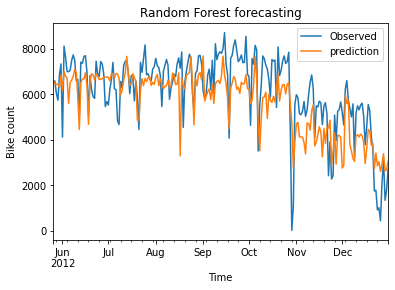

In [31]:
results_df_rf.plot(ylabel='Bike count', xlabel='Time', title='Random Forest forecasting')

### XGBoost

#### Model 2: Vanila XGB

In [32]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)

In [33]:
for col in ['month', 'weekday']:
    X_train[col] = X_train[col].astype('int64')
xgb_model.fit(X_train, Y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Feature importance: We find that humidity, atemp and windspeed are the most important features 

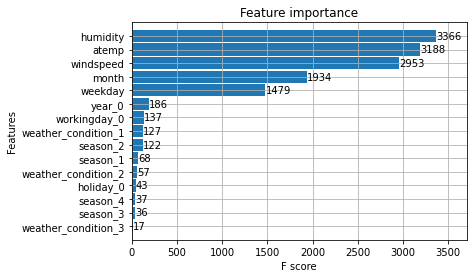

In [35]:
_ = plot_importance(xgb_model, height=0.9)

In [36]:
#Accuracy of the model
xg = xgb_model.score(X_train,Y_train)
print('Accuracy of the model :', xg)

Accuracy of the model : 0.9999999999991533


In [37]:
for col in ['month', 'weekday']:
    X_test[col] = X_test[col].astype('int64')
xgb_pred = xgb_model.predict(X_test)

### Performance of the model

In [38]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(Y_test,xgb_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(Y_test,xgb_pred)
mape = mean_absolute_percentage_error(Y_test, xgb_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)
print('Mean Absolute percentage error :', mape)

Root mean square error : 1126.5874867148123
Mean absolute error : 939.8571999289773
Mean Absolute percentage error : 105.5961206072944


In [39]:
results_df_xgb = test_set['total_count'].to_frame()
results_df_xgb.rename(columns={'total_count':'Observed'}, inplace=True)
results_df_xgb['prediction'] = xgb_model.predict(X_test)

<AxesSubplot:title={'center':'XGBoost forecasting'}, xlabel='Time', ylabel='Bike count'>

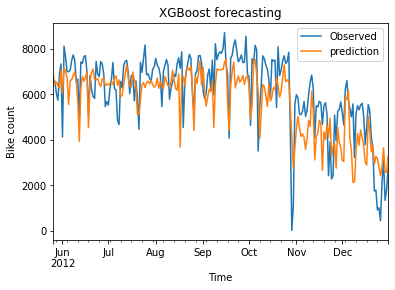

In [40]:
results_df_xgb.plot(ylabel='Bike count', xlabel='Time', title='XGBoost forecasting')

### Model 3: Optimized XGBoost (using Hyperparameter optimization)

In [41]:
tscv = TimeSeriesSplit(n_splits=7)

param_dist = {
    "max_depth": [3, 4, 5, 10, 25],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "num_leaves": [50, 100, 200],
    "n_estimators": [50, 100, 150],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.5, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.9, 0.95, 1.0],
}
xgb_rgs = XGBRegressor(random_state=666)
xgb_gs = RandomizedSearchCV(xgb_rgs, 
                           n_jobs=6, 
                           n_iter=500,
                           param_distributions=param_dist, 
                           cv = tscv, 
                           scoring="neg_mean_absolute_error", 
                           verbose=5, random_state=666)
xgb_gs.fit(X_train, Y_train)

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 444 tasks      | elapsed:   12.8s
[Parallel(n_jobs=6)]: Done 768 tasks      | elapsed:   20.3s
[Parallel(n_jobs=6)]: Done 1164 tasks      | elapsed:   28.8s
[Parallel(n_jobs=6)]: Done 1632 tasks      | elapsed:   40.4s
[Parallel(n_jobs=6)]: Done 2172 tasks      | elapsed:   54.1s
[Parallel(n_jobs=6)]: Done 2784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 3468 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 3500 out of 3500 | elapsed:  1.5min finished


[13:42:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=7),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=500, n_jobs=6,
                   param_distributions={'colsample_bytree': [0.9, 0.95, 1.0],
                              

In [42]:
for col in ['month', 'weekday']:
    X_test[col] = X_test[col].astype('int64')
xgbgs_pred = xgb_gs.predict(X_test)

### Performance of the model

In [43]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(Y_test,xgbgs_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(Y_test,xgbgs_pred)
mape = mean_absolute_percentage_error(Y_test, xgbgs_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)
print('Mean Absolute percentage error :', mape)

Root mean square error : 948.4009891299273
Mean absolute error : 781.1745133833451
Mean Absolute percentage error : 74.46629165921614


## Comparing models 1, 2, and 3, we find that the RMSE score for model 3 is the lowest and hence we choose this model as our final model

### Save this model as final model

In [45]:
joblib.dump(xgb_gs, 'ml.model')

['ml.model']

In [46]:
results_df_xgb_bs = test_set['total_count'].to_frame()
results_df_xgb_bs.rename(columns={'total_count':'Observed'}, inplace=True)
results_df_xgb_bs['prediction'] = xgb_gs.predict(X_test)

<AxesSubplot:title={'center':'XGBoost (Optimized) forecasting'}, xlabel='Time', ylabel='Bike count'>

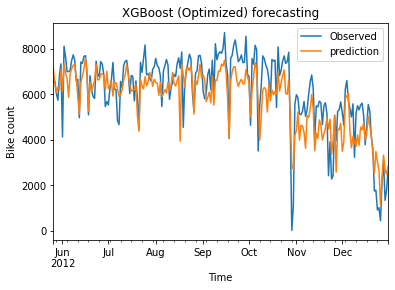

In [47]:
results_df_xgb_bs.plot(ylabel='Bike count', xlabel='Time', title='XGBoost (Optimized) forecasting')

# Forecast: Run the model on unseen data and predict the bike demand 

## In this example, I've tried to predict the bike demand for the first 3 months of 2013. 
### Note: I've created a synthetic dataset from previous data to create the new dataset

In [50]:
n_steps = 90 # No. of days
seasonal = 366
forecast_raw_data = X_train[seasonal:seasonal+n_steps]

In [51]:
X_forecast = xgb_model.predict(forecast_raw_data)

In [52]:
X_forecast

array([1951.0006, 2236.0002, 2367.999 , 3272.0027, 4097.9995, 4521.    ,
       3424.999 , 2375.999 , 3598.0024, 2176.9998, 4096.999 , 3214.    ,
       2493.0002, 2310.9998, 2298.    , 2935.    , 3376.0007, 3291.9998,
       3163.001 , 1301.0001, 1976.9998, 2432.    , 4339.0005, 4269.9966,
       4074.9993, 3455.9998, 4023.    , 3243.001 , 3623.999 , 4508.9995,
       4579.0044, 3761.0024, 4150.998 , 2832.0002, 2946.9998, 3784.0015,
       4374.9995, 2801.9985, 3830.001 , 3831.    , 2168.9995, 1529.0001,
       3421.9998, 3921.9993, 4168.9995, 3004.9993, 4154.    , 4318.0005,
       2689.0005, 3128.9976, 3776.9995, 4772.9995, 5061.996 , 3487.0022,
       2732.0002, 3389.0012, 4321.999 , 4363.0005, 1834.0035, 4989.9995,
       3194.0046, 4066.    , 3422.9995, 3333.001 , 3955.998 , 4916.0005,
       5382.0005, 4569.0005, 4118.    , 4911.0015, 5298.001 , 5846.999 ,
       6312.    , 6191.9966, 4377.999 , 7836.    , 5892.001 , 6153.0005,
       6093.001 , 6230.001 , 6871.001 , 8362.001 , 

# Forecast plot

In [53]:
observed = np.append(df['total_count'].values, [np.nan for i in np.arange(90)])

In [54]:
predicted = np.append([np.nan for i in np.arange(len(X_train))], xgbgs_pred)
predicted = np.append(predicted, [np.nan for i in np.arange(90)])

In [55]:
forecast = np.append([np.nan for i in np.arange(len(df))], X_forecast)

<AxesSubplot:title={'center':'Bike Sharing forecasting'}, xlabel='Time', ylabel='Bike count'>

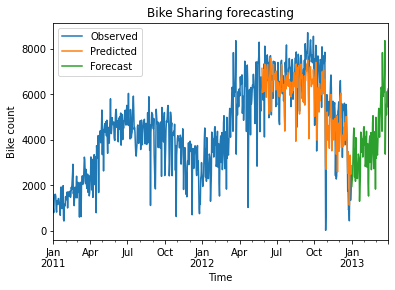

In [56]:
rng = pd.date_range(start='2011-01-01', periods=821, freq='D')
final_df = pd.DataFrame({'datetime':rng, 'Observed':observed, 'Predicted': predicted, 'Forecast':forecast})
final_df.set_index('datetime', inplace=True)
final_df.plot(ylabel='Bike count', xlabel='Time', title='Bike Sharing forecasting')